# Connect to drive & import libraries

In [ ]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
%tensorflow_version 2.x

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import os
from keras.engine import Layer
import matplotlib.pyplot as plt
import keras
import numpy as np
import nltk
import tqdm
import tensorflow_hub as hub
import string
from keras import backend as K

In [ ]:
tf.__version__

'2.3.0'

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!pip install bert-for-tf2

In [ ]:
import bert

# Constants

In [ ]:
# data parameters
test_data_percentage = 0.2
# model parameters
learning_rate = 0.0002
batch_size = 32
max_sequence_length = 128
number_of_epochs = [1, 10]
# model links
bert_model_hub_link = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'
elmo_model_hub_link = 'https://tfhub.dev/google/elmo/3'

# Reading & Pre-processing the data

In [ ]:
metaphor_sentences, literal_sentences = [], []

metaphor_words = []

import pandas as pd

file_1_df = pd.read_csv('drive/My Drive/Metaphor Detection/Data-metaphoric-or-literal.txt', sep='\t')
file_1_df.head(3)

file_1_df['sentence'] = [str(x).replace('</b>', '').replace('<b>', '') for x in file_1_df['sentence'].values]
file_1_df.head()

with open('drive/My Drive/Metaphor Detection/TroFi/metaphorical.txt', 'r') as fp:
  lines = fp.read().split('./.\n')
print(lines[0:2])

metaphor_sentences.extend(lines)

metaphor_sentences.extend(file_1_df[file_1_df['class']=='metaphorical'].sentence.values.tolist())

with open('drive/My Drive/Metaphor Detection/TroFi/literal.txt', 'r') as fp:
  lines = fp.read().split('./.\n')
print(lines[1])

literal_sentences.extend(lines)

literal_sentences.extend(file_1_df[file_1_df['class']=='literal'].sentence.values.tolist())

X = literal_sentences + metaphor_sentences
y = [0]*len(literal_sentences)+[1]*len(metaphor_sentences)
print(len(X), len(y))

["But in the short-term it will absorb a lot of top management 's energy and attention , '' says Philippe Haspeslagh , a business professor at the European management school , Insead , in Paris ", 'Shocks from one-time changes in the terms of trade should be absorbed by adjustments in exchange-rate terms -- not price levels ']
The yellow beta carotene pigment absorbs blue -LRB- not yellow -RRB- laser light 
5033 5033


In [ ]:
all_Y = y
all_X = X

## Create bert tokenizer

In [ ]:
bert_layer = hub.KerasLayer(bert_model_hub_link)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
bert_tokenizer_instance = bert.bert_tokenization.FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

### Bert functions for mask and id and segment id

In [ ]:
def convert_text_to_number_and_fix_length(this_x, tokenizer_mod):
  this_x_ids = tokenizer_mod.convert_tokens_to_ids(this_x,)
  if len(this_x_ids) >= max_sequence_length:
    this_x_fix_len = this_x_ids[:max_sequence_length]
  else:
    this_x_fix_len = this_x_ids + [0]*(max_sequence_length - len(this_x_ids)) 
  return this_x_fix_len

def create_mask_for_input(this_x):
  if len(this_x) >= max_sequence_length:
    this_x_masks = [1]*max_sequence_length
  else:
    this_x_masks = [1]*len(this_x) + [0] * (max_sequence_length - len(this_x))
  return this_x_masks

def create_req_bert_inputs(all_X, tokenizer_mod):
  X_input_ids, X_input_masks, X_segment_ids = [], [], []

  for this_x in tqdm.tqdm(all_X, position=0, leave=True):
    X_input_ids.append(convert_text_to_number_and_fix_length(this_x, tokenizer_mod))
    X_input_masks.append(create_mask_for_input(this_x))
    X_segment_ids.append([0 for _ in range(max_sequence_length)])

  return X_input_ids, X_input_masks, X_segment_ids

## Clean and tokenize 

In [ ]:
def clean_text(all_X, tokenizer_mod=None):
  nltk_eng_stopwords = nltk.corpus.stopwords.words('english')
  converted_X = []
  for this_x in all_X:
    this_x_tokenized = tokenizer_mod.tokenize(this_x)
    converted_X.append(this_x_tokenized)
  return converted_X

def convert_y_to_0_and_1(all_Y):
  label_number_mapping = {0: [1, 0], 1: [0, 1]}
  converted_y = [label_number_mapping[val] for val in all_Y]
  return converted_y

In [ ]:
all_X_cleaned_using_bert = clean_text(all_X, bert_tokenizer_instance)

In [ ]:
all_y_converted = convert_y_to_0_and_1(all_Y)

### Testing BERT results

In [ ]:
print('X[0] => before: {} and after: {}'.format(all_X[0], all_X_cleaned_using_bert[0]))
print('Y[0] => before: {} and after: {}'.format(all_Y[0], all_y_converted[0]))

X[0] => before: An Energy Department spokesman says the sulfur dioxide might be simultaneously recoverable through the use of powdered limestone , which tends to absorb the sulfur  and after: ['an', 'energy', 'department', 'spokesman', 'says', 'the', 'sulfur', 'dioxide', 'might', 'be', 'simultaneously', 'recover', '##able', 'through', 'the', 'use', 'of', 'powder', '##ed', 'limestone', ',', 'which', 'tends', 'to', 'absorb', 'the', 'sulfur']
Y[0] => before: 0 and after: [1, 0]


## Test Train split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_X_cleaned_using_bert, all_y_converted, test_size=test_data_percentage, random_state=42)

# Creating Model

## Using Bert

In [ ]:
train_input_ids, train_input_masks, train_segment_ids = create_req_bert_inputs(X_train, bert_tokenizer_instance)
test_input_ids, test_input_masks, test_segment_ids = create_req_bert_inputs(X_test, bert_tokenizer_instance)

100%|██████████| 1007/1007 [00:00<00:00, 43244.23it/s]


In [ ]:
type(train_input_masks)
np.asarray(train_input_masks, dtype=np.int32)

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)

In [ ]:
bert_model_preped_input = [np.asarray(train_input_ids, dtype=np.int32), np.asarray(train_input_masks, dtype=np.int32), np.asarray(train_segment_ids, dtype=np.int32)]
len(bert_model_preped_input), bert_model_preped_input[0].shape, bert_model_preped_input[0][1].shape

(3, (4026, 128), (128,))

In [ ]:
y_train = np.asarray(y_train)
type(bert_model_preped_input), type(bert_model_preped_input[0]), type(y_train), bert_model_preped_input[0][0]

(list,
 numpy.ndarray,
 numpy.ndarray,
 array([21497,  4187, 12629,  2000,  3071,  2556,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,   

In [ ]:
this_optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

In [ ]:
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32,name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32,name="input_mask")
  segment_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int32,name="segment_ids")
  bert_layer = hub.KerasLayer(bert_model_hub_link,trainable=False)
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
  pooling_lay = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
  dense = tf.keras.layers.Dense(768, activation='relu')(pooling_lay)
  pred = tf.keras.layers.Dense(2, activation='softmax')(dense)
  model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pred)
  return model 

In [ ]:
def plot_accuracy_and_loss(file_save_name, history):
  plt.plot(history.history['accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.show()
  plt.cla()
  plt.plot(history.history['loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.show()
  plt.cla()

In [ ]:
def evaluate_model(model):
  bert_model_test_input = [np.asarray(test_input_ids, dtype=np.int32), np.asarray(test_input_masks, dtype=np.int32), np.asarray(test_segment_ids, dtype=np.int32)]
  predicted_y = model.predict(bert_model_test_input)
  number_label_mapping = {0: 'ham', 1:'spam'}
  y_test_conv = [number_label_mapping[np.argmax(val)] for val in y_test]
  predicted_y_conv = [number_label_mapping[np.argmax(val)] for val in predicted_y]
  print('Accuracy:', accuracy_score(y_test_conv, predicted_y_conv))
  print('Classification report:', classification_report(y_test_conv, predicted_y_conv))
  print('F1 (Micro):', f1_score(y_test_conv, predicted_y_conv, average='micro'))
  print('F1 (Macro):', f1_score(y_test_conv, predicted_y_conv, average='macro'))
  print('F1 (Weighted):', f1_score(y_test_conv, predicted_y_conv, average='weighted'))
  print('Recall (Micro):', recall_score(y_test_conv, predicted_y_conv, average='micro'))
  print('Recall (Macro):', recall_score(y_test_conv, predicted_y_conv, average='macro'))
  print('Recall (Weighted):', recall_score(y_test_conv, predicted_y_conv, average='weighted'))
  print('Precision (Micro):', precision_score(y_test_conv, predicted_y_conv, average='micro'))
  print('Precision (Macro):', precision_score(y_test_conv, predicted_y_conv, average='macro'))
  print('Precision (Weighted):', precision_score(y_test_conv, predicted_y_conv, average='weighted'))
  y_test_for_auc = [np.argmax(val) for val in y_test]
  y_predicted_for_auc = [np.argmax(val) for val in predicted_y]
  fpr, tpr, thresholds = metrics.roc_curve(y_test_for_auc, y_predicted_for_auc, pos_label=1)
  print('AUC:', metrics.auc(fpr, tpr))

In [ ]:
val_counts_in_train_y = {}
for val in y_train:
  if not str(val) in val_counts_in_train_y:
    val_counts_in_train_y[str(val)] = 0
  val_counts_in_train_y[str(val)] += 1
val_counts_in_train_y

{'[0 1]': 1898, '[1 0]': 2128}

In [ ]:
val_counts_in_test_y = {}
for val in y_test:
  if not str(val) in val_counts_in_test_y:
    val_counts_in_test_y[str(val)] = 0
  val_counts_in_test_y[str(val)] += 1
val_counts_in_test_y

{'[0, 1]': 447, '[1, 0]': 560}

Number of epochs: 10
Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_4 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 i

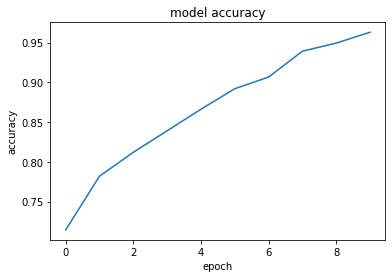

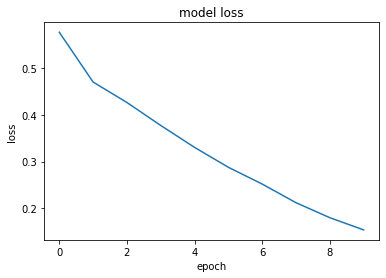

Accuracy: 0.7686196623634558
Classification report:               precision    recall  f1-score   support

         ham       0.79      0.79      0.79       560
        spam       0.74      0.74      0.74       447

    accuracy                           0.77      1007
   macro avg       0.77      0.77      0.77      1007
weighted avg       0.77      0.77      0.77      1007

F1 (Micro): 0.7686196623634558
F1 (Macro): 0.7655080537241415
F1 (Weighted): 0.7685391897262321
Recall (Micro): 0.7686196623634558
Recall (Macro): 0.7653303771172899
Recall (Weighted): 0.7686196623634558
Precision (Micro): 0.7686196623634558
Precision (Macro): 0.7656997583729377
Precision (Weighted): 0.7684724403135137
AUC: 0.7653303771172899
Number of epochs: 20
Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(N

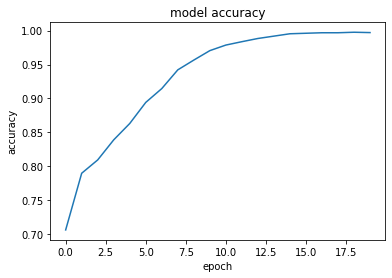

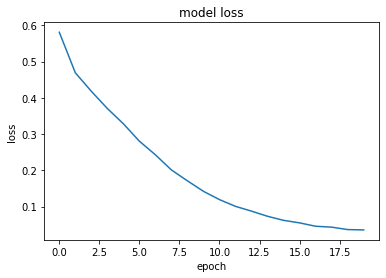

Accuracy: 0.7487586891757696
Classification report:               precision    recall  f1-score   support

         ham       0.76      0.80      0.78       560
        spam       0.73      0.69      0.71       447

    accuracy                           0.75      1007
   macro avg       0.75      0.74      0.74      1007
weighted avg       0.75      0.75      0.75      1007

F1 (Micro): 0.7487586891757696
F1 (Macro): 0.7438068719461732
F1 (Weighted): 0.747803695852919
Recall (Micro): 0.7487586891757696
Recall (Macro): 0.742507590284436
Recall (Weighted): 0.7487586891757696
Precision (Micro): 0.7487586891757696
Precision (Macro): 0.7462257645818122
Precision (Weighted): 0.7479396596663463
AUC: 0.742507590284436
Number of epochs: 100
Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(No

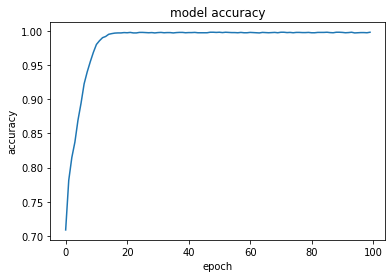

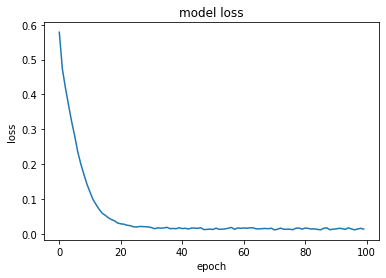

Accuracy: 0.7477656405163853
Classification report:               precision    recall  f1-score   support

         ham       0.78      0.76      0.77       560
        spam       0.71      0.74      0.72       447

    accuracy                           0.75      1007
   macro avg       0.74      0.75      0.75      1007
weighted avg       0.75      0.75      0.75      1007

F1 (Micro): 0.7477656405163853
F1 (Macro): 0.7455957827730257
F1 (Weighted): 0.7482322765902262
Recall (Micro): 0.7477656405163853
Recall (Macro): 0.7468060882070949
Recall (Weighted): 0.7477656405163853
Precision (Micro): 0.7477656405163853
Precision (Macro): 0.7449857244825124
Precision (Weighted): 0.7492888821787814
AUC: 0.7468060882070949


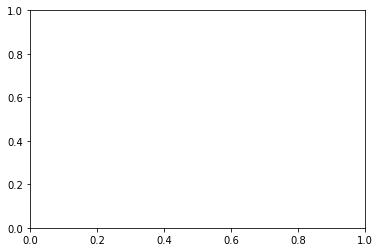

In [ ]:
for epochs in [10, 20, 100]:
  print('Number of epochs:', epochs)
  model = create_model()
  print(model.summary())
  model.compile(loss='binary_crossentropy', optimizer=this_optimizer, metrics=['accuracy'])
  history = model.fit(
      bert_model_preped_input, 
      y_train,
      epochs=epochs,
      batch_size=batch_size
  )
  print('Done training')
  image_save_file_name = 'drive/My Drive/CA5_Sabri_810198312/Results/Q1_bert_model‌_no_preprocess_{}_epochs'.format(epochs)
  plot_accuracy_and_loss(image_save_file_name, history)
  evaluate_model(model)

In [ ]:
train_input_ids, train_input_masks, train_segment_ids = create_req_bert_inputs(all_X_cleaned_using_bert, bert_tokenizer_instance)
bert_model_preped_input = [np.asarray(train_input_ids, dtype=np.int32), np.asarray(train_input_masks, dtype=np.int32), np.asarray(train_segment_ids, dtype=np.int32)]
all_Y = np.asarray(all_Y)
model = create_model()
model.compile(loss='binary_crossentropy', optimizer=this_optimizer, metrics=['accuracy'])
history = model.fit(
    bert_model_preped_input, 
    all_Y,
    epochs=10, 
    batch_size = 32
)

100%|██████████| 5033/5033 [00:00<00:00, 58747.55it/s]


Epoch 1/10
158/158 [==============================] - 24s 153ms/step - loss: 0.7019 - accuracy: 0.5037
Epoch 2/10
158/158 [==============================] - 24s 152ms/step - loss: 0.6944 - accuracy: 0.5053
Epoch 3/10
158/158 [==============================] - 24s 153ms/step - loss: 0.6936 - accuracy: 0.5053
Epoch 4/10
158/158 [==============================] - 24s 152ms/step - loss: 0.6934 - accuracy: 0.5098
Epoch 5/10
158/158 [==============================] - 24s 153ms/step - loss: 0.6933 - accuracy: 0.4965
Epoch 6/10
158/158 [==============================] - 24s 153ms/step - loss: 0.6933 - accuracy: 0.4991
Epoch 7/10
158/158 [==============================] - 24s 153ms/step - loss: 0.6933 - accuracy: 0.5067
Epoch 8/10
158/158 [==============================] - 24s 153ms/step - loss: 0.6932 - accuracy: 0.5035
Epoch 9/10
158/158 [==============================] - 24s 153ms/step - loss: 0.6932 - accuracy: 0.4957
Epoch 10/10
158/158 [==============================] - 24s 153ms/step - l

In [ ]:
covid_texts = []
df1 = pd.read_csv('drive/My Drive/Metaphor Detection/Data-Texts/corona_tweets_01.csv', header=None)
df2 = pd.read_csv('drive/My Drive/Metaphor Detection/Data-Texts/corona_tweets_32.csv', header=None)

covid_texts = df1[1].values.tolist()+df2[1].values.tolist()
covid_ids = df1[0].values.tolist()+df2[0].values.tolist()

test_input_ids, test_input_masks, test_segment_ids = create_req_bert_inputs(clean_text(covid_texts, bert_tokenizer_instance), bert_tokenizer_instance)
bert_model_test_input = [np.asarray(test_input_ids, dtype=np.int32), np.asarray(test_input_masks, dtype=np.int32), np.asarray(test_segment_ids, dtype=np.int32)]
predicted_y = model.predict(bert_model_test_input)
predicted_y_conv = [np.argmax(val) for val in predicted_y]

100%|██████████| 9561/9561 [00:00<00:00, 64246.67it/s]


In [ ]:
lable_counts = {0:0, 1:0}
for item in predicted_y_conv:
  lable_counts[item]+=1
lable_counts

{0: 3647, 1: 5914}

In [ ]:
5914/9661

0.612151951143774

In [ ]:
metaphor_sentiment_mapping = {'pos':{0:0, 1:0}, 'neg':{0:0, 1:0}}
df11 = pd.read_csv('drive/My Drive/Metaphor Detection/corona_tweets_01.csv', header=None)
df11 = df11[df11[0].isin(covid_ids)]
df21 = pd.read_csv('drive/My Drive/Metaphor Detection/corona_tweets_32.csv', header=None)
df21 = df21[df21[0].isin(covid_ids)]
print(df11.shape, df21.shape)
for _, row in df11.iterrows():
  if row[0] in covid_ids:
    ind = covid_ids.index(row[0])
    if row[1]<0:
      metaphor_sentiment_mapping['neg'][predicted_y_conv[ind]] += 1
    else:
      metaphor_sentiment_mapping['pos'][predicted_y_conv[ind]] += 1
for _, row in df21.iterrows():
  if row[0] in covid_ids:
    ind = covid_ids.index(row[0])
    if row[1]<0:
      metaphor_sentiment_mapping['neg'][predicted_y_conv[ind]] += 1
    else:
      metaphor_sentiment_mapping['pos'][predicted_y_conv[ind]] += 1
metaphor_sentiment_mapping

(4804, 2) (4757, 2)


{'neg': {0: 865, 1: 1394}, 'pos': {0: 2783, 1: 4519}}